# Problem
Klasyfikacja białych krwinek na rozmazach morfologicznych.

## Zbiór danych
Zbiór danych składa się z 12444 zdjęć rozmazów morfologicznych (9957 - zbiór treningowy, 2487 - zbiór testowy)

In [1]:
from datasets import get_data

X_train, y_train = get_data('./datasets/TRAIN/')
X_test, y_test = get_data('./datasets/TEST/')

Getting EOSINOPHIL images from ./datasets/TRAIN/
Getting LYMPHOCYTE images from ./datasets/TRAIN/
Getting MONOCYTE images from ./datasets/TRAIN/
Getting NEUTROPHIL images from ./datasets/TRAIN/
Getting EOSINOPHIL images from ./datasets/TEST/
Getting LYMPHOCYTE images from ./datasets/TEST/
Getting MONOCYTE images from ./datasets/TEST/
Getting NEUTROPHIL images from ./datasets/TEST/


In [2]:
print(
    f'X_train: {X_train.shape}',
    f'y_train: {y_train.shape}',
    f'X_test: {X_test.shape}',
    f'y_test: {y_test.shape}',
    sep='\n'
)

X_train: (9957, 120, 160, 3)
y_train: (9957,)
X_test: (2487, 120, 160, 3)
y_test: (2487,)


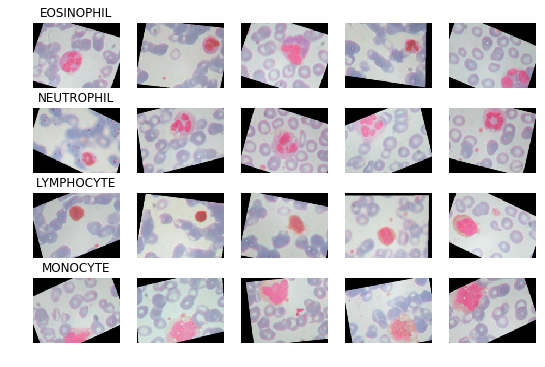

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

classes = set(y_train)
samples_per_class = 5
plt.subplots(figsize=(9, 6))
gs = GridSpec(len(classes), samples_per_class)
for cls, cls_name in enumerate(classes):
    idxs = np.flatnonzero(y_train == cls_name)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(gs[cls, i])
        plt.imshow(X_train[idx])
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

In [5]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

encoder = LabelEncoder()
encoder.fit(y_test)
y_train_svm = encoder.transform(y_train)
y_test_svm = encoder.transform(y_test)
y_train = np_utils.to_categorical(y_train_svm)
y_test = np_utils.to_categorical(y_test_svm)

Using TensorFlow backend.


## HoG features, klasyfikator SVM

In [6]:
import numpy as np

from utils import extract_hog

hog_params = {
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2)
}
X_train_hog = np.array([extract_hog(X, **hog_params) for X in X_train])
X_test_hog = np.array([extract_hog(X, **hog_params) for X in X_test])

In [7]:
X_train_hog.shape

(9957, 9576)

In [ ]:
from sklearn.svm import LinearSVC

hog_svm = LinearSVC(C=1.0, verbose=True)
hog_svm.fit(X_train_hog, y_train_svm)
score = hog_svm.score(X_test_hog, y_test_svm)
print(f'SVM with HOG features accuracy: {score * 100:.2f}%')

[LibLinear]

In [ ]:
X_test_hog.shape

## Prosta sieć neuronowa

In [6]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Lambda, Conv2D, MaxPooling2D, Activation, Dropout, Input
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

simple_nn = Sequential()
simple_nn.add(Lambda(lambda x: x/127.5 - 1., input_shape=(120, 160, 3), output_shape=(120, 160, 3)))
simple_nn.add(Flatten())
simple_nn.add(Dense(16, activation='relu'))
simple_nn.add(Dense(8, activation='relu'))
simple_nn.add(Dense(4, activation='sigmoid'))

simple_nn.compile(loss='binary_crossentropy',
                  optimizer='sgd',
                  metrics=['accuracy'])

In [7]:
simple_nn_history = simple_nn.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.3)

Train on 6969 samples, validate on 2988 samples
Epoch 1/50
6969/6969 [==============================] - 8s 1ms/step - loss: 0.5788 - acc: 0.7309 - val_loss: 0.5716 - val_acc: 0.7497
Epoch 2/50
6969/6969 [==============================] - 5s 671us/step - loss: 0.5583 - acc: 0.7503 - val_loss: 0.5621 - val_acc: 0.7499
Epoch 3/50
6969/6969 [==============================] - 5s 678us/step - loss: 0.5551 - acc: 0.7490 - val_loss: 0.5579 - val_acc: 0.7500
Epoch 4/50
6969/6969 [==============================] - 5s 690us/step - loss: 0.5504 - acc: 0.7495 - val_loss: 0.5510 - val_acc: 0.7492
Epoch 5/50
6969/6969 [==============================] - 5s 735us/step - loss: 0.5478 - acc: 0.7496 - val_loss: 0.5673 - val_acc: 0.7500
Epoch 6/50
6969/6969 [==============================] - 5s 675us/step - loss: 0.5443 - acc: 0.7490 - val_loss: 0.5493 - val_acc: 0.7479
Epoch 7/50
6969/6969 [==============================] - 5s 686us/step - loss: 0.5395 - acc: 0.7508 - val_loss: 0.5419 - val_acc: 0.7499
Ep

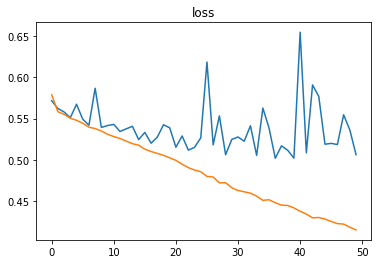

In [8]:
h = simple_nn_history.history
plt.plot(h['val_loss'])
plt.plot(h['loss'])
plt.title('loss')
plt.show()

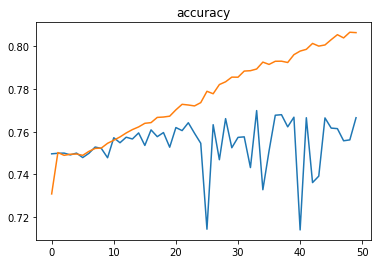

In [9]:
plt.plot(h['val_acc'])
plt.plot(h['acc'])
plt.title('accuracy')
plt.show()

In [10]:
scores = simple_nn.evaluate(X_test, y_test)
print(f'\n{simple_nn.metrics_names[1]}: {scores[1] * 100:.2f}%')

2487/2487 [==============================] - 1s 331us/step

acc: 74.87%


In [11]:
simple_nn.save_weights('./models/simple_nn.h5')

## CNN

In [12]:
cnn = Sequential()
cnn.add(Lambda(lambda x: x/127.5 - 1., input_shape=(120, 160, 3), output_shape=(120, 160, 3)))
cnn.add(Conv2D(32, (3, 3), input_shape=(120, 160, 3)))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Conv2D(32, (3, 3)))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Conv2D(64, (3, 3)))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Flatten())
cnn.add(Dense(64))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.7))
cnn.add(Dense(4, activation='sigmoid'))

cnn.compile(loss='binary_crossentropy',
            optimizer='rmsprop',
            metrics=['accuracy'])

In [13]:
cnn_history = cnn.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.3)

Train on 6969 samples, validate on 2988 samples
Epoch 1/50
6969/6969 [==============================] - 16s 2ms/step - loss: 0.5610 - acc: 0.7410 - val_loss: 0.4208 - val_acc: 0.8025
Epoch 2/50
6969/6969 [==============================] - 11s 2ms/step - loss: 0.4335 - acc: 0.8027 - val_loss: 0.3458 - val_acc: 0.8306
Epoch 3/50
6969/6969 [==============================] - 11s 2ms/step - loss: 0.3409 - acc: 0.8460 - val_loss: 0.2373 - val_acc: 0.8982
Epoch 4/50
6969/6969 [==============================] - 11s 2ms/step - loss: 0.2893 - acc: 0.8744 - val_loss: 0.2084 - val_acc: 0.9105
Epoch 5/50
6969/6969 [==============================] - 11s 2ms/step - loss: 0.2507 - acc: 0.8907 - val_loss: 0.1911 - val_acc: 0.9080
Epoch 6/50
6969/6969 [==============================] - 11s 2ms/step - loss: 0.2226 - acc: 0.9040 - val_loss: 0.1730 - val_acc: 0.9277
Epoch 7/50
6969/6969 [==============================] - 11s 2ms/step - loss: 0.2095 - acc: 0.9129 - val_loss: 0.1336 - val_acc: 0.9401
Epoch 8

In [14]:
scores = cnn.evaluate(X_test, y_test)
print(f'\n{cnn.metrics_names[1]}: {scores[1] * 100:.2f}%')

2487/2487 [==============================] - 2s 686us/step

acc: 93.10%


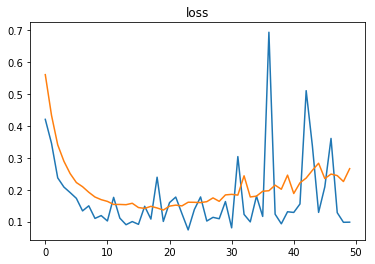

In [15]:
h = cnn_history.history
plt.plot(h['val_loss'])
plt.plot(h['loss'])
plt.title('loss')
plt.show()

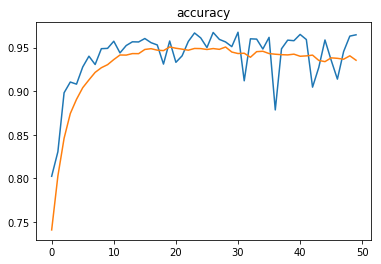

In [16]:
plt.plot(h['val_acc'])
plt.plot(h['acc'])
plt.title('accuracy')
plt.show()

## VGG16

In [49]:
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

vgg_base_model = VGG16(include_top=False, weights='imagenet')
vgg_input = Input(shape=(120, 160, 3))
vgg_x = Lambda(lambda x: preprocess_input(x))(vgg_input)
vgg_output = vgg_base_model(vgg_x)

transfer_model = Flatten()(vgg_output)
transfer_model = Dense(64, activation='relu')(transfer_model)
predictions = Dense(4, activation='softmax')(transfer_model)

vgg_model = Model(inputs=vgg_input, outputs=predictions)

layers = vgg_base_model.layers[:-2]
for layer in layers:
    layer.trainable = False

vgg_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [35]:
cnn_history = vgg_model.fit(X_train, y_train, epochs=25, batch_size=16, validation_split=0.3)

Train on 6969 samples, validate on 2988 samples
Epoch 1/25
6969/6969 [==============================] - 50s 7ms/step - loss: 5.9755 - acc: 0.6267 - val_loss: 6.0462 - val_acc: 0.6228
Epoch 2/25
6969/6969 [==============================] - 49s 7ms/step - loss: 5.9875 - acc: 0.6265 - val_loss: 6.0462 - val_acc: 0.6228
Epoch 3/25
6969/6969 [==============================] - 49s 7ms/step - loss: 5.9875 - acc: 0.6265 - val_loss: 6.0462 - val_acc: 0.6228
Epoch 4/25
6969/6969 [==============================] - 49s 7ms/step - loss: 5.9875 - acc: 0.6265 - val_loss: 6.0462 - val_acc: 0.6228
Epoch 5/25
6969/6969 [==============================] - 49s 7ms/step - loss: 5.9875 - acc: 0.6265 - val_loss: 6.0462 - val_acc: 0.6228
Epoch 6/25
6969/6969 [==============================] - 49s 7ms/step - loss: 5.9875 - acc: 0.6265 - val_loss: 6.0462 - val_acc: 0.6228
Epoch 7/25
6969/6969 [==============================] - 49s 7ms/step - loss: 5.9875 - acc: 0.6265 - val_loss: 6.0462 - val_acc: 0.6228
Epoch 8

In [36]:
scores = vgg_model.evaluate(X_test, y_test)
print(f'\n{cnn.metrics_names[1]}: {scores[1] * 100:.2f}%')

2487/2487 [==============================] - 12s 5ms/step

acc: 62.53%


## CNN Codes

In [ ]:
import tensorflow as tf
from keras import backend as K

# vgg_model.layers.pop()
# vgg_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
# vgg_model_cc = Model(inputs=vgg_model.input, outputs=vgg_model.output)
# print(vgg_model.summary())
foo = Flatten()(vgg_model)

print(foo.summary())

with tf.Session() as sess:
    K.set_session(sess)
    K.set_learning_phase(0)  # 0 - test,  1 - train

    model = vgg_model

    cnn_codes = vgg_model.predict(X_test, batch_size=16, verbose=1)

## SVM on CNN Codes

In [ ]:
from sklearn.svm import LinearSVC

# cc_svm = LinearSVC(C=1.0, verbose=True)
# cc_svm.fit(train_cnn_codes, y_train)
# score = cc_svm.score(test_cnn_codes, y_test_cc)
# print(f'SVM with CNN Codes features accuracy: {score * 100:.2f}%')